Get visual representation of how model accuracy does based on volatility of the ticker. 
- pull in apis
- get volatility score and volatility cat. at the end, i can put them on a scatterplot and have the color reflect category, x-axis reflect score. should be a positive correlation. 
- randomly get 30 tickers for each category. fit model and get metrics. 
    - use if statements

In [1]:
import requests
import yfinance as yf
import pandas as pd
import random
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

c:\Users\Shane\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get Ticker Metadata
# ------------------------------------------------------------------
FINNHUB_API_KEY = 'cuaq7shr01qof06j5bfgcuaq7shr01qof06j5bg0'
EXCHANGE_CODE = 'US' 

url = f'https://finnhub.io/api/v1/stock/symbol?exchange={EXCHANGE_CODE}&token={FINNHUB_API_KEY}'

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    tickers_data = response.json()

    # Extract ticker symbols from the response
    tickers = [item['symbol'] for item in tickers_data] 

    print(tickers)

except requests.exceptions.RequestException as e:
    print(f"-- Error fetching data: {e} --")

['IBHH', 'ALEDY', 'INOQ', 'BSJQ', 'HPSIF', 'PBT', 'CYTOF', 'SSTRF', 'HYDW', 'FLCE', 'BRNY', 'STXG', 'WLFFF', 'PTEL', 'ISRLU', 'WCC.PRA', 'RVCB', 'TRUIF', 'BWMN', 'TNHDF', 'BMMWF', 'AXP', 'FRECF', 'TR', 'MSSA', 'POLA', 'SGIPF', 'CRD.A', 'MGFCF', 'ARDNF', 'LNXSY', 'ACWX', 'KYRNF', 'EMN', 'RSVLS', 'GWYT', 'UIS', 'IMG', 'HECO', 'NCTKY', 'CYPXF', 'OJIPF', 'SPE', 'FSHP', 'MSBC', 'ICDX', 'RFNTS', 'ECX', 'ABQQ', 'OGOFF', 'TRRE', 'CCOZY', 'BCHMY', 'ITRO', 'ISHM', 'BTTAY', 'KYOCY', 'IDINF', 'ASCLF', 'INCZY', 'LDDR', 'BADEF', 'LILA', 'APMU', 'PKCOF', 'PMDI', 'CSDX', 'VIVNS', 'RWGI', 'MWUEF', 'XLG', 'BBBS', 'TCHI', 'MRPT', 'LDRT', 'QBCRF', 'LGOV', 'CATF', 'NVTQF', 'LYLD', 'DMRRP', 'IROHR', 'PKW', 'ADIV', 'ADARF', 'JULQ', 'JAMGF', 'CLSM', 'CRPGF', 'AHT.PRG', 'LUCY', 'ML.WS', 'KNCAF', 'BJGBF', 'DVLP', 'SDNI', 'AREC', 'IWY', 'PFGTF', 'MDMXF', 'SDSYA', 'ZZZOF', 'LEXI', 'CSLLY', 'KEY.PRI', 'TUSK', 'UDIRF', 'ALEX', 'IONAF', 'WEJTY', 'ONL', 'RSSGS', 'SCFFF', 'PBAU', 'MRNY', 'KUNUF', 'APRO', 'NUVB', 'OERL

In [3]:
def load_data(ticker):
    """
    Downloads historical market data for a given ticker symbol.

    Parameters:
    ticker (str): The ticker symbol of the stock to download data for.

    Returns:
    pd.DataFrame: A DataFrame containing the historical market data for the specified ticker.
    """
    data = yf.download(ticker, period='max') # returns relevant data in df
    data.reset_index(inplace=True) # reset multindex, output is index list of tuples
    cols = list(data.columns) # convert index to list
    cols[0] = ('Date', '') 
    cols = [i[0] for i in cols] # return first element of cols tuples
    data.columns = cols # set as column names
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    return data

In [4]:
category_ct_dict = {
    'Low': 0,
    'Medium-Low': 0,
    'Medium': 0,
    'Medium-High': 0,
    'High': 0
}

In [5]:
def get_volatility(data):
    volatility = data.daily_returns.std() * np.sqrt(252)
    if volatility < 0.2:
        category = "Low"
    elif volatility < 0.4:
        category = "Medium-Low"
    elif volatility < 0.6:
        category = "Medium"
    elif volatility < 0.8:
        category = "Medium-High"
    else:
        category = "High"
    return category, volatility

In [6]:
def get_period_params(data, volatility):
    if len(data)/365 < 8:
        period_unit = int(len(data)/4)
        forecast_period = period_unit
        train_period = len(data)
    else:
        period_unit = 365
        forecast_period = period_unit
        train_period = forecast_period * 4 if volatility < 0.6 else forecast_period * 8
    return train_period, period_unit, forecast_period

In [7]:
cv_func = lambda model_name, train_period, period_unit, forecast_period: cross_validation(model_name, 
                                              initial=f'{train_period} days', 
                                              period=f'{period_unit} days', 
                                              horizon=f'{forecast_period} days', 
                                              parallel="processes")

In [8]:
len_tickers = len(tickers)

In [9]:
# later, incorporate winsorization and grid search for hyperparameter tuning

def score_ticker_mapes():
    mapes = []
    tickers_modeled = []
    volatility_list = []
    avg_price_list = []
    len_list = []
    while True:
        category, volatility = '', 0
        ticker_n = random.randint(0, len(tickers))
        ticker_to_model = tickers.pop(ticker_n) # .pop() ensures that the ticker is removed from the list
        if len(yf.download(ticker_to_model)) > 365:
            data = load_data(ticker_to_model)
        else:
            continue
        data['daily_returns'] = data.Close.pct_change() # add to return
        category, volatility = get_volatility(data)
        if category_ct_dict[category] < 30:
            tickers_modeled.append(ticker_to_model)
            volatility_list.append(category)
            avg_price_list.append(data.Close.mean())
            len_list.append(len(data))
            category_ct_dict[category] += 1
            train_period, period_unit, forecast_period = get_period_params(data, volatility)
            df_train = data[['Date', 'Close']].iloc[-train_period:]
            df_train.columns = ['ds', 'y']
            m = Prophet().fit(df_train)
            df_cv = cv_func(m, train_period, period_unit, forecast_period)
            df_p = performance_metrics(df_cv, rolling_window=1)
            mapes.append(df_p['mape'].values[0])
        if all(value >= 30 for value in category_ct_dict.values()):
            break 
    return mapes, tickers_modeled, volatility_list, avg_price_list, len_list

In [10]:
mapes, tickers_modeled, volatility_list, avg_price_list, len_list = score_ticker_mapes()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
17:06:17 - cmdstanpy - INFO - Chain [1] start processing
17:06:17 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
17:06:19 - cmdstanpy - INFO - Chain [1] start processing
17:06:19 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
17:06:20 - cmdstanpy - INFO - Chain [1] start processing
17:06:21 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
[*********************100%**************

In [11]:
category_ct_dict

{'Low': 30, 'Medium-Low': 30, 'Medium': 30, 'Medium-High': 30, 'High': 30}

In [12]:
len(tickers_modeled)

150

In [13]:
len(mapes)

150

In [14]:
len(volatility_list)

150

In [15]:
df = pd.DataFrame({
    'ticker': tickers_modeled, 
    'volatility': volatility_list, 
    'mape': mapes, 
    'avg_price': avg_price_list, 
    'len': len_list
    })
df.head()

,ticker,volatility,mape,avg_price,len
0,ORSX,High,48.088875,5.695674,5052
1,SRTTY,Medium-High,0.371558,4.881675,1499
2,EBWK,High,148.936565,2.818620,4177
3,KODK,High,0.720892,9.442565,2862
4,EGMCF,High,2.173594,0.504595,1888


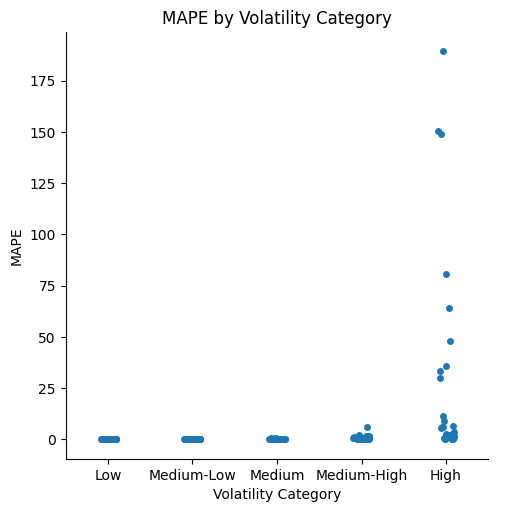

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'] 

# Create the catplot
sns.catplot(x='volatility', y='mape', data=df, kind='strip', order=order) 

# Customize the plot (optional)
plt.xlabel('Volatility Category')
plt.ylabel('MAPE')
plt.title('MAPE by Volatility Category')

# Show the plot
plt.show()

In [20]:
high_volatility = df[df['volatility'] == 'High']
high_volatility.sort_values('mape', ascending=True).head()

,ticker,volatility,mape,avg_price,len
30,SPXA,High,0.149723,0.021924,4024
52,TGOPY,High,0.372705,5.583477,3961
62,CPADF,High,0.386954,1.522638,2717
31,RTMAF,High,0.389869,7.044271,5274
8,NVAAF,High,0.404952,0.194763,1790


In [18]:
filtered_df = df[df['volatility'] != 'High']
filtered_df.volatility.value_counts()

volatility
Medium-High    30
Low            30
Medium-Low     30
Medium         30
Name: count, dtype: int64

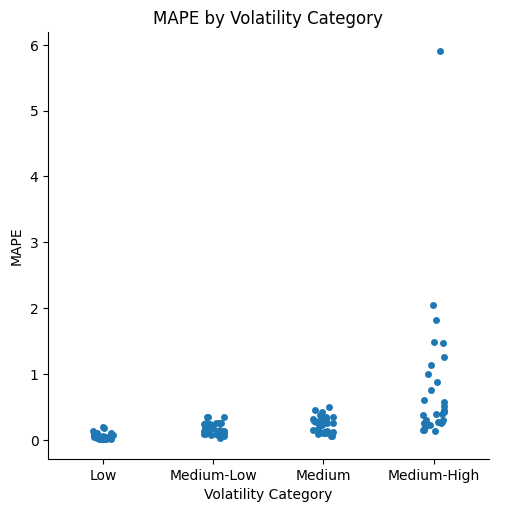

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['Low', 'Medium-Low', 'Medium', 'Medium-High'] 

# Create the catplot
sns.catplot(x='volatility', y='mape', data=filtered_df, kind='strip', order=order) 

# Customize the plot (optional)
plt.xlabel('Volatility Category')
plt.ylabel('MAPE')
plt.title('MAPE by Volatility Category')

# Show the plot
plt.show()